# Summary
- [Data](#Data)
- [Model](#Model)
- [Training](#Training)
- [Evaluation](#Evaluation)
- [Visualization](#Visualization)
    - [Interpretation](#Interpretation)

# Dependencies

In [8]:
#visualization
import matplotlib.pyplot as plt
#math tools
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import resample
from scipy.signal import decimate
#machine learning
import torch
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)
#utils
from time import time
from os.path import join
from os import listdir
import warnings
from sklearn.exceptions import DataConversionWarning

cuda


# Utils

In [61]:
measure2index={"y-coordinate":0,"x-coordinate":1,"timestamp":2, "button_status":3,"tilt":4, "elevation":5,"pressure":6}
index2measure=list(measure2index.keys())

task2index={"spiral":0,"l":1,"le":2 ,"les":3,"lektorka" :4,"porovnat":5,"nepopadnout":6, "tram":7}
index2task=list(task2index.keys())

one_hot=np.identity(8)

In [62]:
def timeSince(since):
    now = time()
    s = now - since
    m = np.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [349]:
def return_results(train_metrics,valid_metrics,early_stopping,flat_falses):
    train_metrics,valid_metrics=np.asarray(train_metrics),np.asarray(valid_metrics)
    model_name="LSTM" if is_lstm else "GRU"
    task_name=index2task[task] if task else str(task)
    results="{} ; {} ; {} ; {} ; {} ; {} ; {} ; {} ; {} ; {} ; {:.2f} (+ {:.2f}) ; {:.2f} (+ {:.2f}) ".format(
    task_name,model_name,downsampling_factor,learning_rate,hidden_size,num_layers,bidirectional,carry_over,dropout,clip,
    np.mean(early_stopping),np.std(early_stopping),np.mean(train_metrics[:,1]),np.std(train_metrics[:,1]))
    
    valid_metrics=valid_metrics.T
    for metric in valid_metrics[1:]:#don't care about the loss
        mean,std=np.mean(metric),np.std(metric)
        results+="; {:.2f} (+ {:.2f}) ".format(mean,std)
    results+=" ; "
    results+=" ; ".join(map(str, flat_falses))
    return results

In [64]:
def confusion_matrix(y_true,y_pred):
    tn, fp, fn, tp=0,0,0,0
    false_i=[]
    for i, (target, pred) in enumerate(list(zip(y_true,y_pred))):
        if target==0:#condition negative
            if pred==0:
                tn+=1
            else:
                fp+=1
                false_i.append(i)
        else:#condition positive
            if pred==0:
                fn+=1
                false_i.append(i)
            else:
                tp+=1
    return tn, fp, fn, tp, false_i

# Data
## Loading

In [65]:
data_path=join("..","PaHaW","PaHaW_public")#/00026/00026__1_1.svc"
folder_path=listdir(data_path)
folder_path.sort()

In [66]:
meta_path=join("..","PaHaW","corpus_PaHaW.csv")
meta_data=[]
with open(meta_path) as file:
    for line in file.readlines():
        meta_data.append(line.split(";"))
meta_data.pop(0)
meta_data=np.asarray(meta_data)
labels=[1 if i =="ON" else 0 for i in meta_data[:,4]]


In [67]:
task_path=listdir(join(data_path,folder_path[46]))
task_path.sort()

Subjects 46 (control),
60 (PD) and
66 (control) didn't perform the spiral !


In [319]:
raw=[]
for folder in folder_path:
    subject=[]
    task_path=listdir(join(data_path,folder))
    task_path.sort()
    if len(task_path)!=8:#subject didn't perform the spiral
        subject.append([])#add an empty array so that all tasks are on the same column number
    for task in task_path:
        measures=[]
        path=join(data_path,folder,task)
        with open(path) as file:
            for line in file.readlines():
                measures.append(line.split())
            measures.pop(0)
        subject.append(measures)
    raw.append(subject)

In [320]:
print("(75 subjects, 8 tasks, X task duration*200, 7 recorded signals)")
print(len(raw),len(raw[0]),len(raw[0][0]),len(raw[0][0][0]))

(75 subjects, 8 tasks, X task duration*200, 7 recorded signals)
75 8 1772 7


The task sequence is in average **2286** &rarr; task duration is in average 11.4s  

task | duration | duration std | duration per letters
--|--|--|--
spiral | 2758.75 | 2267.76 | NA
l | 1668.01 | 724.14 | 333
le | 1984.16 | 999.61 | 198
les | 2305.01 | 1095.54 | 153
lektorka | 2608.48 | 1333.76  | 163
porovnat | 2315.08 | 1033.69 |144
nepopadnout | 1469.29 | 650.65 | 133
tram | 3086.13 | 1158.81 | 146

## Task selection

In [283]:
task_name=index2task[0]
task=task2index[task_name]
print(task,task_name)

0 spiral


In [313]:
#discard the subjects that didn't perform spiral
#and convert the data from str to float (not int because we will need to standardize it afterwards)
data=[np.asarray(raw[i][task],dtype=float) for i,subject in enumerate(raw) for task in range(8) if len(raw[i][task])!=0]
#data=[[[raw[i][task][j][6]] for j in range(len(raw[i][task])) ]  for i,subject in enumerate(raw) if len(raw[i][task])!=0]#discard the subjects that didn't perform spiral

targets= [labels[i]  for i,subject in enumerate(raw) for task in range(8) if len(raw[i][task])!=0]
#for multi class #
#spiral_targets=[target[i]  for i,subject in enumerate(raw) if len(raw[i][0])!=0]

assert len(data) == 8*75-3 #8 tasks times 75 subjects minus 3 who didn't perform spiral
print(len(data),len(targets),len(data[0]))

597 597 1772


### Scale then downsample

In [322]:
downsampling_factor=1
task=0
new_task=72#there's only 72 subjects who performed spiral
for i,subject in enumerate(data):
    if i==new_task:
        task+=1
        new_task+=75#there's 75 subjects for every other tasks
    if downsampling_factor==1:#don't downsample
        data[i]=np.concatenate(([one_hot[task] for i in range(len(subject))],scale(subject,axis=0)),axis=1)
    else:
        warnings
        data[i]=decimate(
            scale(subject,axis=0),#scale first
                  downsampling_factor,axis=0)#then downsample
    
print(len(data),len(targets),len(data[0]))
task=None#set to None so we know it's not a unique task setting in evaluation

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


597 597 1772


### Data split
In order to provide for a meaningful comparison with works from Drotar et al. and Moetesum et al. we will evaluate our results using a 10-fold cross validation  
The actual split is done before [Training](#Training)

# Model
- [**Pytorch LSTM doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM)
- [**Pytorch GRU doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.GRU)
- [**Pytorch Linear doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)
- [**Pytorch Binary Cross Entropy loss (BCELoss) doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)

## Definition
Cf. Report #4 for details about the architecture of the model

In [337]:
class Model(torch.nn.Module):
    """
    Args:
        #Vanilla LSTM/GRU
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
            would mean stacking two LSTMs together to form a `stacked LSTM`,
            with the second LSTM taking in outputs of the first LSTM and
            computing the final results. Default: 1
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False``
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
            LSTM layer except the last layer, with dropout probability equal to
            :attr:`dropout`. Default: 0
        bidirectional: If ``True``, becomes a bidirectional LSTM. Default: ``False``
        
        #our model
        batch_size : default : 1
        output_size : default : 1 
        is_lstm : default : True
    """
    def __init__(self, input_size, hidden_size,num_layers=1, bias=True,batch_first=False,
                 dropout=0,bidirectional=False, batch_size=1, output_size=1,is_lstm=True):
        super(Model, self).__init__()
        #Vanilla LSTM/GRU
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias=bias
        self.batch_first=batch_first
        self.dropout=dropout
        self.bidirectional=bidirectional
        #our model
        self.batch_size = batch_size
        self.output_size = output_size

        # Define the encoder (i.e. GRU or LSTM) layer
        if is_lstm:
            self.encoder = torch.nn.LSTM(self.input_size, self.hidden_size, self.num_layers,self.bias,self.batch_first,
                            self.dropout,self.bidirectional)
        else:
            self.encoder = torch.nn.GRU(self.input_size, self.hidden_size, self.num_layers,self.bias,self.batch_first,
                            self.dropout,self.bidirectional)
        
        #define the dropout layer
        self.dropout_layer=torch.nn.Dropout(self.dropout)

        # Define the decoder layer
        self.linear = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
                
    def forward(self, input):
        # Forward pass through encoder layer
        # shape of encoder_out: (seq_len, batch, num_directions * hidden_size)
        # shape of self.hidden: (h_n, c_n), where hidden state h_n and cell state c_n both 
        # have shape (num_layers * num_directions, batch, hidden_size).
        encoder_out, _ = self.encoder(input)
        #print(encoder_out.shape)
        
        if self.bidirectional:
            #sums the outputs : direction left-right and direction right-left
            # encoder_out shape should now be (seq_len, batch,hidden_size)
            encoder_out = encoder_out[: ,: ,: self.hidden_size] + encoder_out[: , :, self.hidden_size: ]
        
        # Only take the output from the final timestep
        drop=self.dropout_layer(encoder_out[-1])
        y_pred = self.linear(drop)
        y_pred = self.sigmoid(y_pred)
        return y_pred.squeeze(0)
    
    """useless if self.hidden's not called in #encoder_out, _ = self.encoder(input)# cf subsequence
    def init_hidden(self):
        h_0 of shape (num_layers * num_directions, batch, hidden_size): 
        tensor containing the initial hidden state for each element in the batch. 
        If the RNN is bidirectional, num_directions should be 2, else it should be 1.

        c_0 of shape (num_layers * num_directions, batch, hidden_size): 
        tensor containing the initial cell state for each element in the batch.
        
        The hidden state is modified in place.
        
        num_directions=1
        if self.bidirectional:
            num_directions=2
            
        
        self.hidden=torch.zeros(self.num_layers*num_directions, self.batch_size, self.hidden_size),
        torch.zeros(self.num_layers*num_directions, self.batch_size, self.hidden_size)"""
    
    def init_forget_bias(self):
        """Following advices of Jozefowicz et al. 2015,
        we initialize the bias of the forget gate to a large value such as 1
        In PyTorch, the forget gate bias is stored as b_hf in bias_hh_l[k] : 
        the learnable hidden-hidden bias of the kth layer (b_hi|b_hf|b_hg|b_ho), of shape (4*hidden_size).
        So b_hf == bias_hh_lk[hidden_size:2*hidden_size]
        
        The weights are modified in-place, like init_hidden(self).
        """
        gen=self.modules()
        _=next(gen)#model summary : don't care about it
        lstm=next(gen)
        if not isinstance(lstm,torch.nn.LSTM):
            raise NotImplementedError("the encoder should be an LSTM and should be the first module of the model")
        
        with torch.no_grad():#so the optimizer doesn't know about this ;)
            lstm.bias_hh_l0[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.bidirectional:
                lstm.bias_hh_l0_reverse[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.num_layers > 1:
                lstm.bias_hh_l1[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
                if lstm.bidirectional:
                    lstm.bias_hh_l1_reverse[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.num_layers > 2:
                lstm.bias_hh_l2[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)    
                if lstm.bidirectional:
                    lstm.bias_hh_l2_reverse[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.num_layers > 3:
                lstm.bias_hh_l3[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)    
                if lstm.bidirectional:
                    lstm.bias_hh_l3_reverse[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.num_layers > 4:
                lstm.bias_hh_l4[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)    
                if lstm.bidirectional:
                    lstm.bias_hh_l4_reverse[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
                                    
            if lstm.num_layers>5:
                raise NotImplementedError("you can only have max 5 layers for now")
                
    def count_params(self):
        """returns (total n° of parameters, n° of trainable parameters)"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total_params, trainable_params

# Training
## step

In [338]:
def step(input, target, model, optimizer, loss_fn, batch_size,clip=None,validation = False):
    if not validation:
        # Zero gradients
        optimizer.zero_grad()    
        
    # Set device options
    input=input.to(device)
    target=target.to(device)
        
    #forward pass
    output=model(input)
    
    # Compute loss
    loss = loss_fn(output, target)
    
    
    
    if not validation:
        # Perform backpropagation
        loss.backward()
        if clip is not None:
            #clip gradients to previent exploding
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        # Adjust model weights
        optimizer.step()
        
        """# carry over regularization SHOULD RESET LSTM NOT MODEL
        if np.random.rand() <carry_over:
            model.init_hidden() """
    
    return loss.item(), output.item()

## epoch

In [339]:
def epoch(data,targets, model, optimizer, loss_fn, batch_size, random_index,clip=None,validation=False):
    losses=[]
    predictions=[]
    condition_targets=[]
    
    for index in random_index:
        condition_targets.append(targets[index])
        #numpy to tensor
        subject=torch.Tensor(data[index]).unsqueeze(1)#add batch dimension
        #truncate then gives shape (channels, seq_len) then add batch dimension
        #subject=torch.Tensor(data[index][0:shortest_spiral]).t().unsqueeze(0)
        
        target=torch.Tensor([targets[index]])        
        loss, prediction =step(subject,target, model, optimizer, loss_fn, batch_size,clip,validation)
        predictions.append(round(prediction))
        losses.append(loss)
    
    #compute metrics
    #tn, fp, fn, tp = metrics.confusion_matrix(y_true=condition_targets,y_pred=predictions,labels=[0,1]).ravel()
    tn, fp, fn, tp, false_i = confusion_matrix(y_true=condition_targets,y_pred=predictions)
    false=[random_index[i] for i in false_i]
    accuracy= (tp+tn)/(tp+tn+fp+fn)
    sensitivity = tp/(tp+fn) if (tp+fn) != 0 else 0.0 #without condition positives the sensitivity should be 0
    specificity = tn/(tn+fp) if (tn+fp)!= 0 else 0.0 #idem
    ppv = tp/(tp+fp) if tp+fp != 0 else 0.0 #without predicted positives the ppv should be 0
    npv = tn/(tn+fn) if tn+fn !=0 else 0.0 #idem
    
    return [np.mean(losses),accuracy,sensitivity,specificity,ppv,npv],false

## Hyperparameters

In [340]:
is_lstm=False
learning_rate = 1e-3
hidden_size=10
num_layers=4
bidirectional=True
dropout=0.0
clip=5.0#clipping value to clip the gradients norm : set to None if you don't want to clip

carry_over=0.0
input_size=len(data[0][0])#==7 if we take all the measures into account, 7+8 if we train on multiple tasks
bias=True
batch_first=False#we should unsqueeze(1) to add a batch dimension
batch_size=1
output_size=1#binary classif : 1 means PD, 0 means control

loss_fn=torch.nn.BCELoss()#Binary cross entropy

## 10 fold cross validation (early stopping)

In [245]:

verbose=False
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(data,targets)
fold_train_metrics,fold_valid_metrics,fold_falses=[],[],[]
start = time()
np.random.seed(1)
save_to_print=""
fold=0
n_epochs=50#max n° of epochs the model will be trained to
patience = 10#n° of epochs without improvement during which the model will wait before stopping

for train_index,test_index in cv_generator:     
    train_metrics,valid_metrics,falses=[],[],[]

    torch.manual_seed(1)#random seed for weights init
    model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                 dropout,bidirectional, batch_size, output_size, is_lstm)
    if isinstance(model.encoder,torch.nn.LSTM):
        model.init_forget_bias()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    if fold==0:        
        print("(total n° of parameters, n° of trainable parameters)\n",model.count_params())

    best_accuracy=0
    #best_loss=10000.0
    impatience=0
    for i in range(n_epochs):                
        to_print=""
        np.random.shuffle(train_index)
        np.random.shuffle(test_index)
        #training
        model.train()
        [loss,accuracy,sensitivity,specificity,ppv,npv],_=epoch(
        data, targets, model, optimizer, loss_fn, batch_size, train_index,clip,validation=False)
        train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        to_print+="\n\nfold n°{}, epoch n°{}, spent {}".format(fold,i,timeSince(start))
        to_print+="\nTRAINING : loss {:.3f}, accuracy {:.3f}".format(loss,accuracy)

        #validation
        model.eval()
        [loss,accuracy,sensitivity,specificity,ppv,npv],false=epoch(
            data, targets, model, optimizer, loss_fn, batch_size, test_index,validation=True)    
        valid_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        falses.append(false)
        to_print+="\nVALIDATION : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
            loss,accuracy,sensitivity,specificity,ppv,npv)      

        #patience update        
        if accuracy <= best_accuracy:#`<=` no improvement is considered bad !#loss>=best_loss:
            impatience+=1
        else:
            best_accuracy=accuracy #best_loss=loss#
            impatience=0

        if verbose:
            print(to_print)
        save_to_print+=to_print

        #early stopping
        if impatience >= patience:
            save_to_print+="\nEarly stopped."
            break     

    fold_train_metrics.append(train_metrics)
    fold_valid_metrics.append(valid_metrics)
    fold_falses.append(falses)
    fold+=1
if not verbose:
    print(save_to_print)

new experiment : 10 ; 4
(total n° of parameters, n° of trainable parameters)
 (3411, 3411)


fold n°0, epoch n°0, spent 2m 10s
TRAINING : loss 0.699, accuracy 0.500
VALIDATION : loss 0.697, accuracy 0.500, sensitivity  1.000, specificity 0.000, ppv 0.500, npv 0.000

fold n°0, epoch n°1, spent 4m 24s
TRAINING : loss 0.686, accuracy 0.547
VALIDATION : loss 0.699, accuracy 0.500, sensitivity  1.000, specificity 0.000, ppv 0.500, npv 0.000

fold n°0, epoch n°2, spent 6m 36s
TRAINING : loss 0.691, accuracy 0.641
VALIDATION : loss 0.699, accuracy 0.500, sensitivity  1.000, specificity 0.000, ppv 0.500, npv 0.000

fold n°0, epoch n°3, spent 8m 51s
TRAINING : loss 0.692, accuracy 0.469
VALIDATION : loss 0.702, accuracy 0.500, sensitivity  0.750, specificity 0.250, ppv 0.500, npv 0.500

fold n°0, epoch n°4, spent 11m 3s
TRAINING : loss 0.696, accuracy 0.469
VALIDATION : loss 0.714, accuracy 0.250, sensitivity  0.250, specificity 0.250, ppv 0.250, npv 0.250

fold n°0, epoch n°5, spent 13m 18s
TR

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))




fold n°0, epoch n°0, spent 0m 33s
TRAINING : loss 0.696, accuracy 0.500
VALIDATION : loss 0.700, accuracy 0.625, sensitivity  0.750, specificity 0.500, ppv 0.600, npv 0.667

fold n°0, epoch n°1, spent 1m 8s
TRAINING : loss 0.660, accuracy 0.594
VALIDATION : loss 0.695, accuracy 0.750, sensitivity  1.000, specificity 0.500, ppv 0.667, npv 1.000

fold n°0, epoch n°2, spent 1m 43s
TRAINING : loss 0.662, accuracy 0.625
VALIDATION : loss 0.725, accuracy 0.500, sensitivity  0.750, specificity 0.250, ppv 0.500, npv 0.500

fold n°0, epoch n°3, spent 2m 18s
TRAINING : loss 0.621, accuracy 0.703
VALIDATION : loss 0.742, accuracy 0.500, sensitivity  0.750, specificity 0.250, ppv 0.500, npv 0.500

fold n°0, epoch n°4, spent 2m 53s
TRAINING : loss 0.650, accuracy 0.625
VALIDATION : loss 0.753, accuracy 0.375, sensitivity  0.500, specificity 0.250, ppv 0.400, npv 0.333

fold n°0, epoch n°5, spent 3m 27s
TRAINING : loss 0.609, accuracy 0.641
VALIDATION : loss 0.730, accuracy 0.500, sensitivity  0.7

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))




fold n°0, epoch n°0, spent 0m 35s
TRAINING : loss 0.690, accuracy 0.609
VALIDATION : loss 0.665, accuracy 0.500, sensitivity  1.000, specificity 0.000, ppv 0.500, npv 0.000

fold n°0, epoch n°1, spent 1m 13s
TRAINING : loss 0.674, accuracy 0.516
VALIDATION : loss 0.652, accuracy 0.625, sensitivity  1.000, specificity 0.250, ppv 0.571, npv 1.000

fold n°0, epoch n°2, spent 1m 50s
TRAINING : loss 0.661, accuracy 0.578
VALIDATION : loss 0.684, accuracy 0.375, sensitivity  0.500, specificity 0.250, ppv 0.400, npv 0.333

fold n°0, epoch n°3, spent 2m 28s
TRAINING : loss 0.655, accuracy 0.609
VALIDATION : loss 0.665, accuracy 0.625, sensitivity  0.750, specificity 0.500, ppv 0.600, npv 0.667

fold n°0, epoch n°4, spent 3m 5s
TRAINING : loss 0.639, accuracy 0.625
VALIDATION : loss 0.718, accuracy 0.375, sensitivity  0.250, specificity 0.500, ppv 0.333, npv 0.400

fold n°0, epoch n°5, spent 3m 42s
TRAINING : loss 0.579, accuracy 0.688
VALIDATION : loss 0.681, accuracy 0.500, sensitivity  0.2

## 1 over 10 fold training (no early stopping)

In [341]:
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(data, targets)

fold=-1

In [342]:
verbose=False

fold+=1
train_metrics,valid_metrics=[],[]
train_index,test_index=next(cv_generator)
print(test_index)
print("fold n°",fold)
torch.manual_seed(1)
model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                 dropout,bidirectional, batch_size, output_size,is_lstm)
if isinstance(model.encoder,torch.nn.LSTM):
    model.init_forget_bias()
model=model.to(device)
print("(total n° of parameters, n° of trainable parameters)\n",model.count_params())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
"""#should unsquueze 0 to add batch dim
model=torch.nn.Sequential(
    torch.nn.Conv1d(7,7,1),
    torch.nn.Conv1d(7,7,1),
    torch.nn.MaxPool1d(1),    
    torch.nn.Conv1d(7,1,1),
    torch.nn.MaxPool1d(1),
    torch.nn.Linear(shortest_spiral,1),
    torch.nn.Sigmoid()    
)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(sum(p.numel() for p in model.parameters()))"""
save_to_print=""
start = time()
np.random.seed(1)
falses=[]

[ 11  12  18  27  62  73  80  85  91 107 112 117 123 150 154 158 164 187
 188 194 203 205 227 238 249 259 273 288 303 304 309 312 338 346 356 358
 368 371 375 380 402 411 415 418 421 427 447 452 455 456 469 476 499 514
 515 529 564 582 594 595 596]
fold n° 0
(total n° of parameters, n° of trainable parameters)
 (7391, 7391)


In [343]:
for i in range(10):  
    to_print=""
    np.random.shuffle(train_index)
    np.random.shuffle(test_index)
    #training
    model.train()
    [loss,accuracy,sensitivity,specificity,ppv,npv],_=epoch(
        data, targets, model, optimizer, loss_fn, batch_size, train_index,clip,validation=False)
    train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
    to_print+="\n\nfold n°{}, epoch n°{}, spent {}".format(fold,i,timeSince(start))
    to_print+="\nTRAINING : loss {:.3f}, accuracy {:.3f}".format(loss,accuracy)
    
    #validation
    model.eval()
    [loss,accuracy,sensitivity,specificity,ppv,npv],false=epoch(
        data, targets, model, optimizer, loss_fn, batch_size, test_index,validation=True)    
    valid_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
    falses.append(false)
    to_print+="\nVALIDATION : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
        loss,accuracy,sensitivity,specificity,ppv,npv)
    
    if verbose:
        print(to_print)    
    save_to_print+=to_print
if not verbose:
    print(save_to_print)



fold n°0, epoch n°0, spent 18m 12s
TRAINING : loss 0.580, accuracy 0.685
VALIDATION : loss 0.546, accuracy 0.754, sensitivity  0.733, specificity 0.774, ppv 0.759, npv 0.750

fold n°0, epoch n°1, spent 37m 15s
TRAINING : loss 0.488, accuracy 0.761
VALIDATION : loss 0.513, accuracy 0.738, sensitivity  0.667, specificity 0.806, ppv 0.769, npv 0.714

fold n°0, epoch n°2, spent 56m 16s
TRAINING : loss 0.457, accuracy 0.778
VALIDATION : loss 0.556, accuracy 0.705, sensitivity  0.533, specificity 0.871, ppv 0.800, npv 0.659

fold n°0, epoch n°3, spent 75m 17s
TRAINING : loss 0.436, accuracy 0.785
VALIDATION : loss 0.683, accuracy 0.721, sensitivity  0.433, specificity 1.000, ppv 1.000, npv 0.646

fold n°0, epoch n°4, spent 94m 17s
TRAINING : loss 0.433, accuracy 0.789
VALIDATION : loss 0.521, accuracy 0.738, sensitivity  0.767, specificity 0.710, ppv 0.719, npv 0.759

fold n°0, epoch n°5, spent 113m 19s
TRAINING : loss 0.415, accuracy 0.776
VALIDATION : loss 0.524, accuracy 0.721, sensitiv

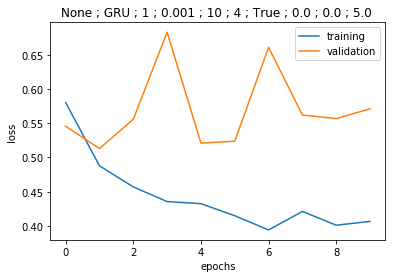

In [350]:
results=return_results(train_metrics,
                  valid_metrics,
                  [len(valid_metrics) for i in range(len(valid_metrics))],
                   falses)

plt.figure()
plt.title(results[0:57])
plt.plot(np.asarray(train_metrics)[:,0],label="training")
plt.plot(np.asarray(valid_metrics)[:,0],label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

## Debug

In [268]:
model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                 dropout,bidirectional, batch_size, output_size)
if isinstance(model.encoder,torch.nn.LSTM):
    model.init_forget_bias()
model=model.to(device)

#shortest_spiral=np.min([len(spiral) for spiral in spirals])
#print(shortest_spiral)

subject=torch.Tensor(data[61]).unsqueeze(1)
target=torch.Tensor([targets[61]])
subject=subject.to(device)
target=target.to(device)

#step(subject, target, model, optimizer, loss_fn, batch_size,clip=None,validation = False)

# Evaluation

In [257]:
folds_lengths=[len(fold) for fold in fold_valid_metrics]
print("number of epochs before early stopping for each fold:\n",folds_lengths)
longest_fold=np.argmax(folds_lengths)
shortest_fold=np.min(folds_lengths)
average_stop=int(round(np.mean(folds_lengths)-patience))-1#-1 to index to it
med_stop=int(round(np.median(folds_lengths)-patience-1))#-1 to index to it

number of epochs before early stopping for each fold:
 [12, 12, 11, 11, 12, 12, 13, 11, 12, 11]


In [258]:
try:
    assert np.max([len(fold) for fold in fold_valid_metrics]) < n_epochs
except AssertionError:
    print("The model didn't early stop therefore fold[-patience-1] is not the best epoch")
else:
    best_falses=[fold[-patience-1] for fold in fold_falses]
    flat_falses = [item for sublist in best_falses for item in sublist]
    flat_falses.sort()
    results=return_results([fold[-patience-1] for fold in fold_train_metrics],
                  [fold[-patience-1] for fold in fold_valid_metrics],
                  [len(fold)-patience for fold in fold_valid_metrics],
                   flat_falses)
    print(results)

spiral ; 1 ; 0.001 ; 100 ; 1 ; False ; 0.0 ; 0.5 ; 5.0 ; 1.70 (+ 0.64) ; 0.55 (+ 0.07) ; 0.67 (+ 0.13) ; 0.60 (+ 0.20) ; 0.73 (+ 0.25) ; 0.76 (+ 0.21) ; 0.66 (+ 0.15)  ; 1 ; 4 ; 6 ; 7 ; 9 ; 12 ; 13 ; 15 ; 18 ; 23 ; 28 ; 29 ; 30 ; 31 ; 36 ; 47 ; 57 ; 59 ; 62 ; 63 ; 66 ; 67 ; 68 ; 69


## 10 fold cross validation with early stopping
**Available in the git repo :**  `experiment results.ods`  
**Cf Report #4 for analysis**   
/!\ validating on the test set /!\  
Average metric over the 10 folds + standard deviation (i.e. we select the best epoch based on the validation accuracy for each fold)  
early stopped : n° of epochs + std  
Every metric is for the validation set if not specified otherwise  
The studied hyperparameter is printed in **bold**.  


## 5 fold cross validation with early stopping
/!\ validating on the test set /!\  
Average metric over the 5 folds + standard deviation (i.e. we select the best epoch based on the validation accuracy for each fold)  
Every metric is for the validation set if not specified otherwise 

 learning_rate |hidden_size|num_layers|bidirectional|dropout|TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--
0.001 | 100 | 1 | False | 0.0 | 0.62 (+ 0.04) | 0.60 (+ 0.05) | 0.63 (+ 0.27) | 0.56 (+ 0.35) | 0.68 (+ 0.18) | 0.50 (+ 0.26) 

## 10 fold cross validation with 1 epoch per fold

 learning_rate |hidden_size|num_layers|bidirectional|dropout|train accuracy | valid accuracy 
--|--|--|--|--|--|--
0.001 | 100 | 2 | True | 0.0 | 0.508 (+ 0.044) | 0.571 (+ 0.107) 

# Visualization

In [185]:
avg_train=np.mean(np.asarray([fold[0:shortest_fold] for fold in fold_train_metrics]),axis=0)
avg_valid=np.mean(np.asarray([fold[0:shortest_fold] for fold in fold_valid_metrics]),axis=0)

## Loss

 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
0.001 | **10** | 1 | True | 0.0 | 5.0 | 5.70 (+ 4.22) | 0.59 (+ 0.06) | 0.67 (+ 0.11) | 0.83 (+ 0.20) | 0.51 (+ 0.25) | 0.65 (+ 0.14) | 0.74 (+ 0.30)

The model seems to overfit less than usual, this is probably because it has way less parameters (~1.5k instead of ~43k)  
Adding an extra layer gives the same behaviour, more or less 

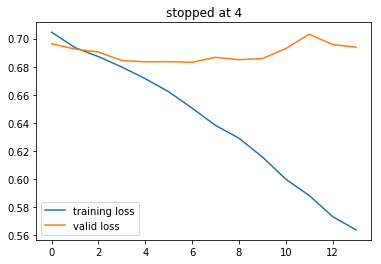

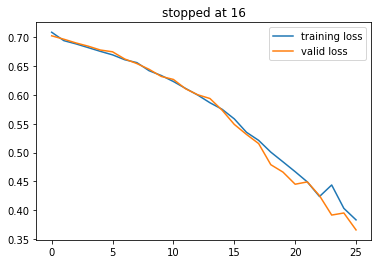

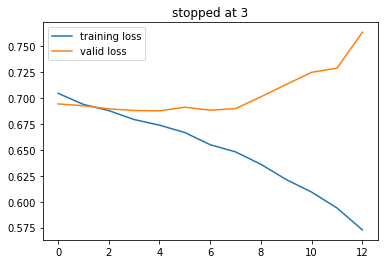

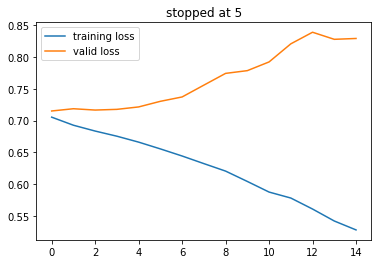

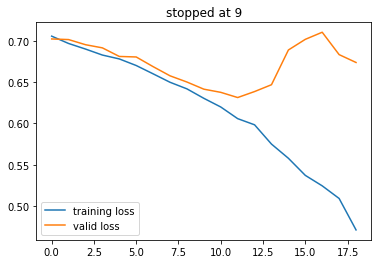

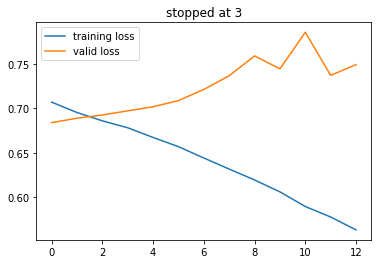

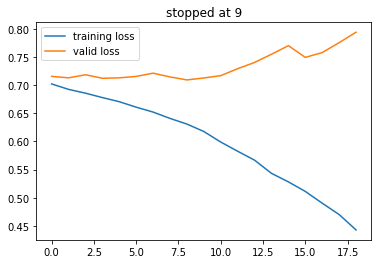

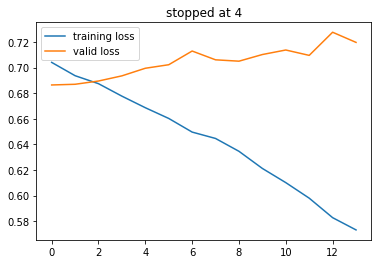

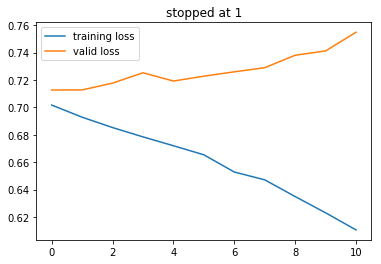

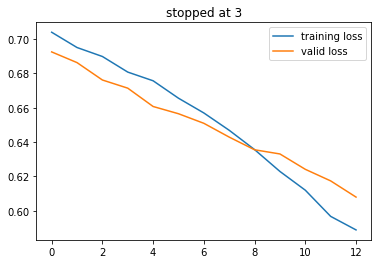

In [179]:
for i in range(10):
    plt.figure()
    plt.title("stopped at "+str(len(fold_train_metrics[i])-patience))
    plt.plot(np.asarray(fold_train_metrics[i])[:,0],label="training loss")
    plt.plot(np.asarray(fold_valid_metrics[i])[:,0],label="valid loss")
    plt.legend()

##### Regularizing with carry over seems to help with overfitting
But the "specificity boost" is even stronger

task	|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|carry over | dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--|--
spirals | 1 | 0.001 | 10 | 2 | True |0.1| 0.5 | 5.0 | 5.00 (+ 4.49) 

![carry_over](carry_over.png)

##### 3 layers gives better results and prevents overfitting
and reverses the "specificity boost" 

task	|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|carry over | dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--|--
spirals | 1 | 0.001 | 10 | 3 | True |0 | 0.5 | 5.0 | 4.90 (+ 4.01)

![3layers](3layers.png)

##### Stronger effect with 4 layers
but the specificity boost comes back  

task|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|carry over | dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--|--
spiral | 1 | 0.001 | 10 | 4 | True |0| 0.5 | 5.0 | 5.50 (+ 3.35) 

![4layers.png](4layers.png)

##### Using more units per layer (50 or 100) gives better results but more overfitting and variance

task	|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--
spirals | 1 | 0.001 | 100 | 1 | True | 0.5 | 5.0 | 5.00 (+ 4.49) 

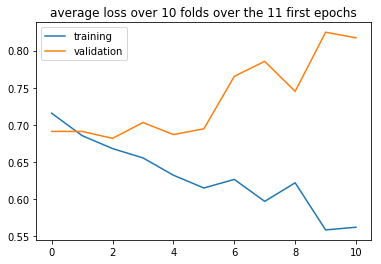

In [87]:
plt.figure()
plt.title("average loss over 10 folds over the {} first epochs".format(shortest_fold))
plt.plot(avg_train[:,0],label="training")
plt.plot(avg_valid[:,0],label="validation")
plt.legend()

##### With 2 layers the effect is augmented (even more with 3)
task	|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--
spiral | 1 | 0.001 | 100 | 2 | True | 0.5 | 5.0 | 4.70 (+ 4.00) 

![2layers.png](2layers.png)

##### The model doesn't behave the same way with the l task (with 2 or 3 layers)
task	|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--
l | 1 | 0.001 | 10 | 2 | True | 0.5 | 5.0 | 4.70 (+ 4.31)

l | 1 | 0.001 | 10 | 2 | True | 0.5 | 5.0 | 4.70 (+ 4.31)


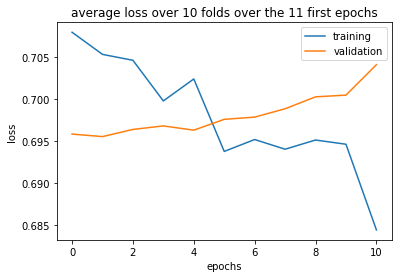

In [105]:
print(results[0:57].replace(";","|"))
plt.figure()
plt.title("average loss over 10 folds over the {} first epochs".format(shortest_fold))
plt.plot(avg_train[:,0],label="training")
plt.plot(avg_valid[:,0],label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

#####  Nor with the tram task

task	|dowsampling factor |learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped 
--|--|--|--|--|--|--|--|--
tram | 1 | 0.001 | 10 | 2 | True | 0.0 | 0.0 | 5.0 | 5.30

![tram](tram.png)

## Accuracy

 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
**0.0001** | 100 | 1 | True | 0.0 | 5.0 | 14.80 (+ 12.37) | 0.63 (+ 0.09) | 0.71 (+ 0.09) | 0.55 (+ 0.27) | 0.87 (+ 0.18) | 0.88 (+ 0.15) | 0.70 (+ 0.16) 

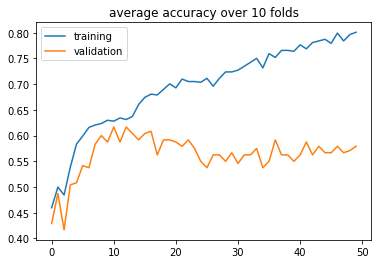

In [104]:
plt.figure()
plt.title("average accuracy over 10 folds")
plt.plot(avg_train[:,1],label="training")
plt.plot(avg_valid[:,1],label="validation")
plt.legend()

 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
0.001 | **10** | 1 | True | 0.0 | 5.0 | 5.70 (+ 4.22) | 0.59 (+ 0.06) | 0.67 (+ 0.11) | 0.83 (+ 0.20) | 0.51 (+ 0.25) | 0.65 (+ 0.14) | 0.74 (+ 0.30)

The model seems to overfit less than usual, this is probably because it has way less parameters (~1.5k instead of ~43k)

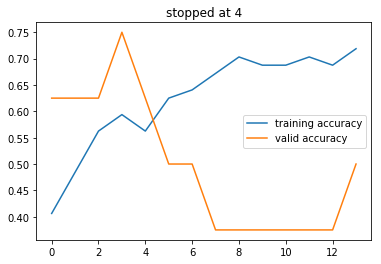

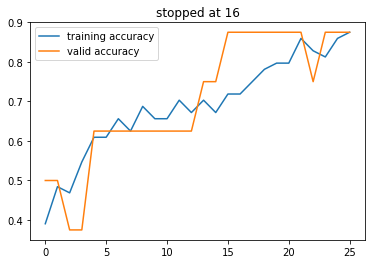

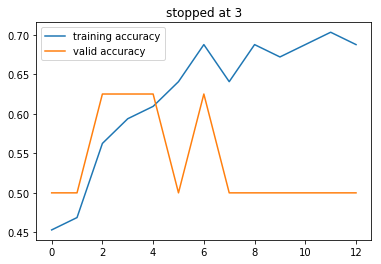

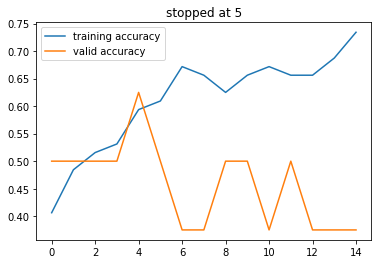

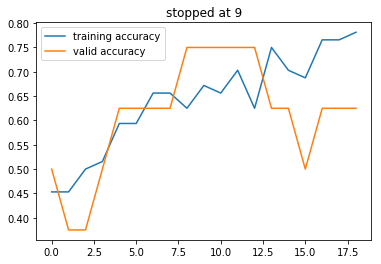

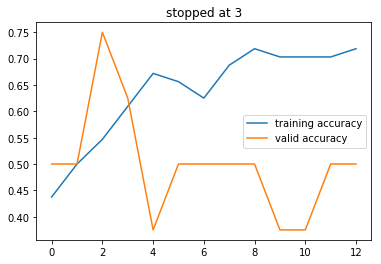

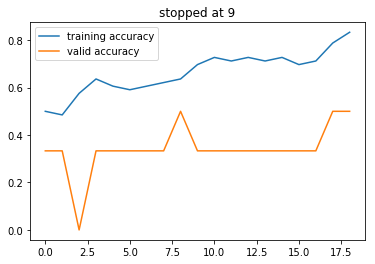

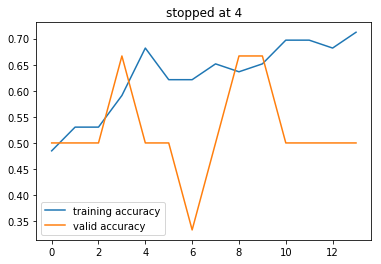

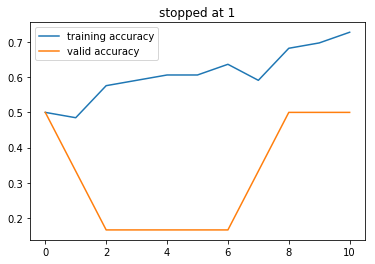

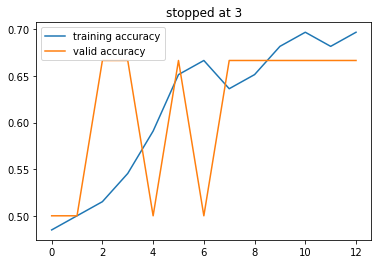

In [180]:
for i in range(10):
    plt.figure()
    plt.title("stopped at "+str(len(fold_train_metrics[i])-patience))
    plt.plot(np.asarray(fold_train_metrics[i])[:,1],label="training accuracy")
    plt.plot(np.asarray(fold_valid_metrics[i])[:,1],label="valid accuracy")
    plt.legend()

##  Interpretation

In [1]:
raw_results="""10	4	TRUE	0	0.5	5	 5.50 (+ 3.35) 	 0.58 (+ 0.10) 	 0.72 (+ 0.15) 	 0.65 (+ 0.38) 
10	3	TRUE	0	0.5	5	 4.90 (+ 4.01) 	 0.59 (+ 0.08) 	 0.72 (+ 0.16) 	 0.84 (+ 0.21) 
10	2	TRUE	0	0.5	5	 4.20 (+ 3.76) 	 0.56 (+ 0.08) 	 0.70 (+ 0.07) 	 0.57 (+ 0.21) 
10	2	TRUE	0.1	0.5	5	 3.40 (+ 2.58) 	 0.57 (+ 0.07) 	 0.71 (+ 0.12) 	 0.45 (+ 0.24) 
10	1	TRUE	0	0.5	5	 3.40 (+ 2.24) 	 0.53 (+ 0.04) 	 0.63 (+ 0.10) 	 0.90 (+ 0.17) 
50	1	TRUE	0	0.5	5	 5.70 (+ 6.78) 	 0.64 (+ 0.13) 	 0.73 (+ 0.11) 	 0.65 (+ 0.20) 
50	2	TRUE	0	0.5	5	 2.30 (+ 2.00) 	 0.52 (+ 0.08) 	 0.66 (+ 0.11) 	 0.68 (+ 0.27) 
100	1	TRUE	0	0.5	5	 5.00 (+ 4.49) 	 0.62 (+ 0.08) 	 0.74 (+ 0.16) 	 0.72 (+ 0.31) 
100	2	TRUE	0	0.5	5	 4.70 (+ 4.00) 	 0.59 (+ 0.07) 	 0.71 (+ 0.15) 	 0.67 (+ 0.31) 
100	3	TRUE	0	0.5	5	 4.70 (+ 3.10) 	 0.57 (+ 0.07) 	 0.68 (+ 0.10) 	 0.70 (+ 0.24) """

results=[r.split("\t") for r in raw_results.split("\n")]

len(results)

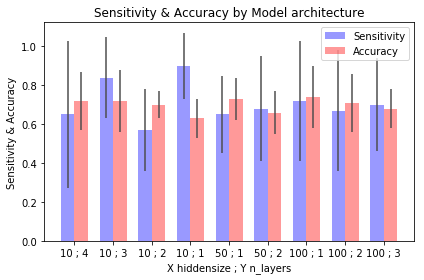

In [34]:
n_groups = len(results)

studied_metric = tuple([float(i[-1][0:5]) for i in results])#(0.74, 0.63, 0.7)
studied_std = tuple([float(i[-1][8:13]) for i in results])#(0.16, 0.1, 0.07)

accuracy_vanilla = tuple([float(i[-2][0:5]) for i in results])
std_vanilla = tuple([float(i[-2][8:13]) for i in results])

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, studied_metric, bar_width,
                alpha=opacity, color='b',
                yerr=studied_std, error_kw=error_config,
                label='Sensitivity')

rects2 = ax.bar(index + bar_width, accuracy_vanilla, bar_width,
                alpha=opacity, color='r',
                yerr=std_vanilla, error_kw=error_config,
                label='Accuracy')

ax.set_xlabel('X hiddensize ; Y n_layers')
ax.set_ylabel('Sensitivity & Accuracy')
ax.set_title('Sensitivity & Accuracy by Model architecture')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(tuple([i[0]+" ; "+i[1] for i in results]))#('100 ; 1', '10 ; 1', '10 ; 2'))
ax.legend()

fig.tight_layout()
plt.show()

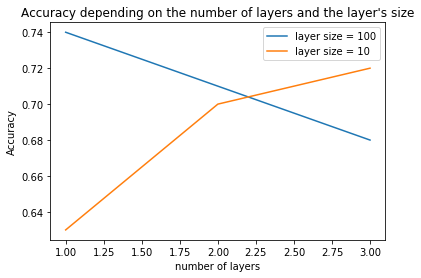

In [124]:
plt.figure()

plt.title("Accuracy depending on the number of layers and the layer's size")
plt.plot(range(1,4),[0.74,0.71,0.68],label="layer size = 100")
plt.plot(range(1,4),[0.63,0.7,0.72],label="layer size = 10")
#plt.errorbar(range(1,4),[0.74,0.71,0.68],[0.16,0.07,0.1],label="layer size = 100", marker='^')
#plt.errorbar(range(1,4),[0.63,0.7,0.72],[0.16,0.15,0.1],label="layer size = 10", marker='^')
plt.xlabel("number of layers")
plt.ylabel("Accuracy")
plt.legend()

## Model weights

In [596]:
fold_train_metrics[0]

[[0.7049412904307246, 0.53125, 0.1875, 0.875, 0.6, 0.5185185185185185]]

torch.Size([30, 15])

In [533]:
generator = model.modules()
print(next(generator))
lstm=next(generator)

Model(
  (encoder): LSTM(7, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [356]:
print("""the learnable input-hidden weights of the kth layer (W_ii|W_if|W_ig|W_io) (with k=0 in our case),
of shape (4*hidden_size x input_size) if LSTM and 
(W_ir|W_iz|W_in) of shape (3*hidden_size x input_size) if GRU""")
print(model.encoder.weight_ih_l0.shape)#lstm.weight_ih_l0.shape)
input_weights=model.encoder.weight_ih_l0.cpu().detach().numpy()

the learnable input-hidden weights of the kth layer (W_ii|W_if|W_ig|W_io) (with k=0 in our case),
of shape (4*hidden_size x input_size) if LSTM and 
(W_ir|W_iz|W_in) of shape (3*hidden_size x input_size) if GRU
torch.Size([30, 15])


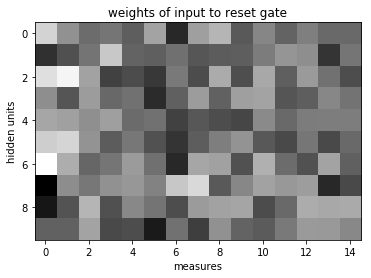

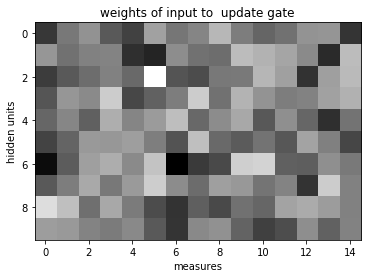

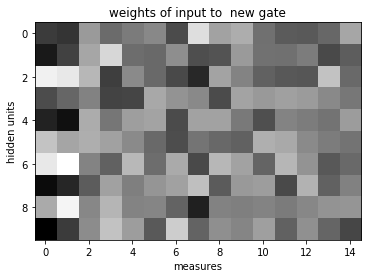

In [363]:
plot_labels="reset gate, update gate, new gate".split(",")
for i,label in enumerate(plot_labels):
    plt.figure()
    plt.title("weights of input to {}".format(label))
    plt.xlabel("measures")
    plt.ylabel("hidden units")
    plt.imshow(input_weights[i*10:i*10+10],cmap='gray')

#### Biases after init at 1


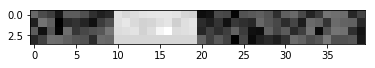

In [358]:
biases=[lstm.bias_hh_l0,
lstm.bias_hh_l0_reverse,
lstm.bias_hh_l1,
lstm.bias_hh_l1_reverse]
for i,b in enumerate(biases):
    biases[i]=b.cpu().detach().numpy()
plt.imshow(biases,cmap='gray')